##Instalaciones previas

In [1]:
%tensorflow_version 1.x
!pip3 install keras==2.2.5

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 4.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


##Imports

In [2]:
from __future__ import print_function
import numpy as np
from google.colab import drive
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


##Carga de Drive

In [3]:
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


##Preproceso 1

In [37]:
content_image=Image.open('/drive/My Drive/Fotos/fotoInstagram.png')#Descomentar si se esta probando la otra foto de Drive
content_image=content_image.resize((512,512))

style_image= Image.open('/drive/My Drive/Fotos/nocheEstrellada.jpg')#Descomentar si se esta probando la otra foto de Drive
style_image=style_image.resize((512,512))

content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
content_array=content_array[:,:,:,0:3]#Descomentar si se esta probando la otra foto de Drive

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


##Preproceso 2

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

##Modelo

In [39]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

##Pesos y capas

In [40]:
#Mejor resultado: c = 0.05, s = 50.0, t = 1.0
##Probados:
##c = 0.05, s = 50.0, t = 1.0
##c = 50, s = 0.05, t = 1.0
##c = 0.05, s = 50.0, t = 20.0

content_weight = 0.05
style_weight = 50
total_variation_weight = 1.0

layers=dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

{'input_4': <tf.Tensor 'concat_3:0' shape=(3, 512, 512, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_3/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_3/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_3/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_3/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_3/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_3/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool_3/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>, 'block4

##Loss

In [41]:
loss=backend.variable(0.)

def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

layer_features=layers['block2_conv2']
print(layer_features.shape)
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

grads = backend.gradients(loss, combination_image)

outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

(3, 256, 256, 128)


##Evaluator

In [42]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
525923700000.0
Iteration 0 completed in 15s
Start of iteration 1
241847420000.0
Iteration 1 completed in 15s
Start of iteration 2
153334270000.0
Iteration 2 completed in 15s
Start of iteration 3
117901050000.0
Iteration 3 completed in 16s
Start of iteration 4
99845290000.0
Iteration 4 completed in 15s
Start of iteration 5
86404194000.0
Iteration 5 completed in 15s
Start of iteration 6
77218914000.0
Iteration 6 completed in 15s
Start of iteration 7
70427250000.0
Iteration 7 completed in 15s
Start of iteration 8
66029187000.0
Iteration 8 completed in 15s
Start of iteration 9
62136906000.0
Iteration 9 completed in 15s


##Muestra Final

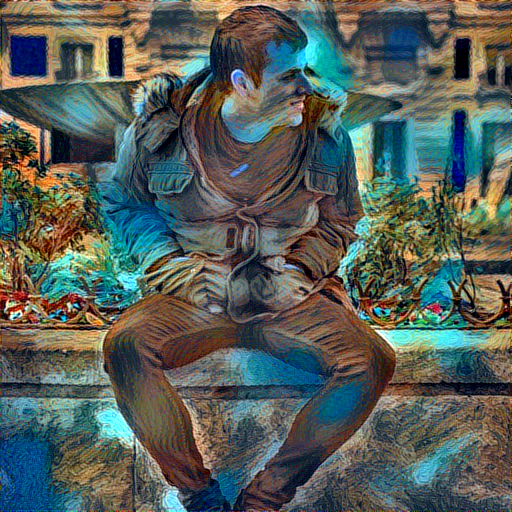

In [43]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)